In [1]:
#Import the CSV file

import pandas as pd

# Path to my dataset
file_path = "cleaned_properties.csv"

# Trying to detect separator (semicolon vs comma)
with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    sep = ';' if ';' in first_line else ','

# Loading into a DataFrame
df = pd.read_csv(file_path, sep=sep, low_memory=False)

print(f"Detected separator: {repr(sep)}")
print("Data loaded successfully!")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
df.head(3)


Detected separator: ','
Data loaded successfully!
Rows: 75508, Columns: 30


,id,price,property_type,subproperty_type,region,province,locality,zip_code,latitude,longitude,...,fl_garden,garden_sqm,fl_swimming_pool,fl_floodzone,state_building,primary_energy_consumption_sqm,epc,heating_type,fl_double_glazing,cadastral_income
0,34221000,225000.0,APARTMENT,APARTMENT,Flanders,Antwerp,Antwerp,2050,51.217172,4.379982,...,0,0.0,0,0,MISSING,231.0,poor,GAS,1,922.0
1,2104000,449000.0,HOUSE,HOUSE,Flanders,East Flanders,Gent,9185,51.174944,3.845248,...,0,0.0,0,0,MISSING,221.0,poor,MISSING,1,406.0
2,34036000,335000.0,APARTMENT,APARTMENT,Brussels-Capital,Brussels,Brussels,1070,50.842043,4.334543,...,0,0.0,0,1,AS_NEW,NaN,MISSING,GAS,0,NaN


In [2]:

# In clean data, check the share of NONE, unknown in all columns
import numpy as np


def check_missing_keywords(df, columns, keywords=None):
    if keywords is None:
        keywords = ['none', 'no data', 'unknown', 'missing', 'na', 'n/a', 'not specified']
    
    results = {}
    for col in columns:
        if col in df.columns:
            # Converting to lowercase string and strip spaces
            col_series = df[col].astype(str).str.strip().str.lower()
            # Creating a mask ("rule/condition") for NaN or empty cells 
            mask_empty = df[col].isna() | (col_series == '') | (col_series == 'nan')
            # Creating a mask for known “missing” words
            mask_keywords = col_series.isin(keywords)
            # Combining both
            mask_total = mask_empty | mask_keywords
            total_missing = mask_total.sum()
            total_rows = len(df)
            
            results[col] = {'count_missing_like': total_missing,'share_missing_like_%': round(100 * total_missing / total_rows, 2)}
    
    return pd.DataFrame(results).T.sort_values('share_missing_like_%', ascending=False)

cols = ['id','price','property_type','subproperty_type','region','province','locality','zip_code','latitude','longitude','construction_year','total_area_sqm','surface_land_sqm','nbr_frontages','nbr_bedrooms','equipped_kitchen','fl_furnished','fl_open_fire','fl_terrace','terrace_sqm','fl_garden','garden_sqm','fl_swimming_pool','fl_floodzone','state_building','primary_energy_consumption_sqm','epc','heating_type','fl_double_glazing','cadastral_income','surface_land_sqm','nbr_bedrooms','equipped_kitchen','fl_open_fire','fl_terrace','terrace_sqm','fl_garden','garden_sqm','fl_floodzone']
check_missing_keywords(df, cols)

,count_missing_like,share_missing_like_%
cadastral_income,44964.0,59.55
surface_land_sqm,36253.0,48.01
construction_year,33388.0,44.22
equipped_kitchen,33022.0,43.73
heating_type,31443.0,41.64
state_building,26642.0,35.28
primary_energy_consumption_sqm,26566.0,35.18
nbr_frontages,26346.0,34.89
epc,24476.0,32.42
latitude,14098.0,18.67


In [3]:
# TO BE ADDED TO THE CLEANING FILE: creating EPC categorization across regions, via creating groups "excellent", "good", "poor", "bad"

# Defining mapping rules for each region

epc_mapping = {
    "Flanders": {
        "A+": "excellent",
        "A": "excellent",
        "B": "good",
        "C": "poor",
        "D": "poor",
        "E": "bad",
        "F": "bad"
    },
    
    "Brussels-Capital": {
        "A": "excellent",
        "B": "good",
        "C": "good",
        "D": "poor",
        "E": "poor",
        "F": "bad",
        "G": "bad"
    },
    
    "Wallonia": {
        "A++": "excellent",
        "A+": "excellent",
        "A": "good",
        "B": "good",
        "C": "poor",
        "D": "poor",
        "E": "poor",
        "F": "bad",
        "G": "bad"
    }
}

# Function that uses the rule on region

def recode_epc(row):
    region = row['region']
    epc = row['epc']

    if pd.isna(region) or pd.isna(epc):
        return np.nan
    
    region_rules = epc_mapping.get(region)

    if region_rules is None:
        return np.nan
    
    return region_rules.get(epc, np.nan)

df['epc_group'] = df.apply(recode_epc, axis =1)
df = df.drop(columns=['epc'])
df = df.rename(columns={'epc_group': 'epc'})
df['epc'].value_counts(dropna=False)




epc
NaN    75508
Name: count, dtype: int64

In [4]:
df.info()
df.describe(include='all')

# Classification of qualitative (numerical) and quantitative(categorical) variables
#  
# Variables:
    #Identifier:
    #   id - nominal
    
    #Target variable:
    #   price - continuous numeric
    
    #Categorical variables:
    #   property_type - nominal
    #   subproperty_type - nominal
    #   region - nominal
    #   province - nominal
    #   locality - nominal
    #   zip_code - nominal (technically numeric but it is used as a category; not included in the analysis)
    #   equipped_kitchen - nominal
    #   heating_type - nominal
    #   ****epc -  ordinal but usually treated as nominal in practice (A-B-C-D-E-F-G is ordered, but gaps aren’t equal)
    #   state_buidling - ordinal but treated as nominal
    #   fl_floodzone - binary
    #   fl_double_glazing - binary
    #   fl_open_fire - binary
    #   fl_terrace - binary
    #   fl_garden - binary
    #   fl_swimming_pool - binary
    #   fl_furnished - binary

    #Numeric variables:
    #   latitude - continuous (not included in the analysis)
    #   longitude - continuous (not included in the analysis)
    #   surface_land_sqm - continuous 
    #   terrace_sqm - continuous
    #   garden_sqm - continuous
    #   total_area_sqm - continuous
    #   primary_energy_consumption_sqm - continuous
    #   cadastral_income - continous

    #Discrete numeric:
    #   nbr_bedrooms - discrete
    #   nbr_frontages - discrete
    #   construction_year - discrete

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75508 entries, 0 to 75507
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75508 non-null  int64  
 1   price                           75508 non-null  float64
 2   property_type                   75508 non-null  object 
 3   subproperty_type                75508 non-null  object 
 4   region                          75505 non-null  object 
 5   province                        75505 non-null  object 
 6   locality                        75505 non-null  object 
 7   zip_code                        75508 non-null  int64  
 8   latitude                        61410 non-null  float64
 9   longitude                       61410 non-null  float64
 10  construction_year               42120 non-null  float64
 11  total_area_sqm                  67893 non-null  float64
 12  surface_land_sqm                

,id,price,property_type,subproperty_type,region,province,locality,zip_code,latitude,longitude,...,fl_garden,garden_sqm,fl_swimming_pool,fl_floodzone,state_building,primary_energy_consumption_sqm,heating_type,fl_double_glazing,cadastral_income,epc
count,7.550800e+04,7.550800e+04,75508,75508,75505,75505,75505,75508.000000,61410.000000,61410.000000,...,75508.000000,72569.000000,75508.000000,75508.000000,75508,4.894200e+04,75508,75508.000000,3.054400e+04,0.0
unique,NaN,NaN,2,23,3,11,43,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7,NaN,8,NaN,NaN,NaN
top,NaN,NaN,HOUSE,HOUSE,Flanders,West Flanders,Brussels,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MISSING,NaN,GAS,NaN,NaN,NaN
freq,NaN,NaN,39255,29730,43423,11797,7956,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26642,NaN,31873,NaN,NaN,NaN
mean,3.973205e+07,4.227730e+05,NaN,NaN,NaN,NaN,NaN,5144.670313,50.886621,4.328681,...,0.218295,115.645069,0.018687,0.543836,NaN,1.688814e+03,NaN,0.676749,1.885941e+03,NaN
std,2.290449e+07,4.383664e+05,NaN,NaN,NaN,NaN,NaN,3005.457468,0.349734,0.950905,...,0.413091,1388.788790,0.135417,0.498078,NaN,1.589342e+05,NaN,0.467721,1.004971e+05,NaN
min,0.000000e+00,7.600000e+04,NaN,NaN,NaN,NaN,NaN,1000.000000,25.761680,-80.191790,...,0.000000,0.000000,0.000000,0.000000,NaN,-1.400000e+02,NaN,0.000000,1.000000e+00,NaN
25%,1.989175e+07,2.420000e+05,NaN,NaN,NaN,NaN,NaN,2240.000000,50.705806,3.764070,...,0.000000,0.000000,0.000000,0.000000,NaN,1.280000e+02,NaN,0.000000,5.450000e+02,NaN
50%,3.972150e+07,3.290000e+05,NaN,NaN,NaN,NaN,NaN,4683.000000,50.900930,4.376711,...,0.000000,0.000000,0.000000,1.000000,NaN,2.420000e+02,NaN,1.000000,8.500000e+02,NaN
75%,5.954125e+07,4.550000e+05,NaN,NaN,NaN,NaN,NaN,8370.000000,51.148643,4.876499,...,0.000000,0.000000,0.000000,1.000000,NaN,3.920000e+02,NaN,1.000000,1.249000e+03,NaN


<Axes: xlabel='price'>

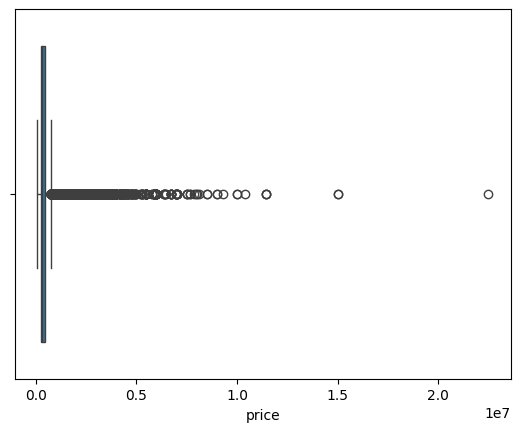

In [5]:
#Boxplot and Historgram PRICE
import seaborn as sns

sns.boxplot(x=df['price'])

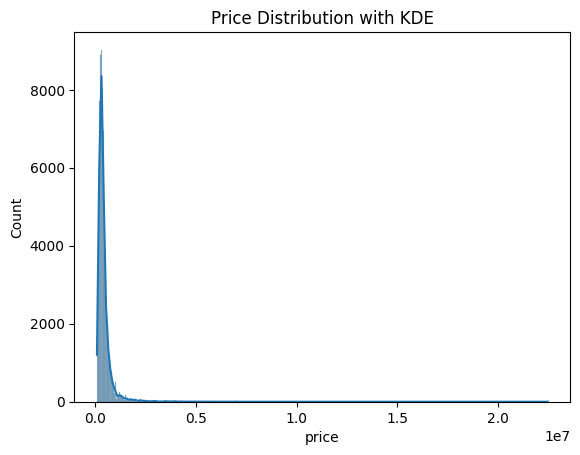

In [6]:
#Skeweness PRICE
import matplotlib.pyplot as plt

sns.histplot(df['price'], kde=True)
plt.title("Price Distribution with KDE")
plt.show()

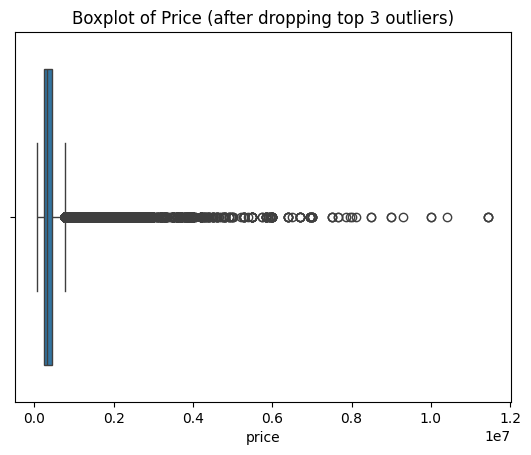

In [7]:
#Remove the highest priced observatrions
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by='price', ascending=False)
df_clean = df_sorted.iloc[3:]  # drop top 3 rows
sns.boxplot(x=df_clean['price'])
plt.title("Boxplot of Price (after dropping top 3 outliers)")
plt.show()

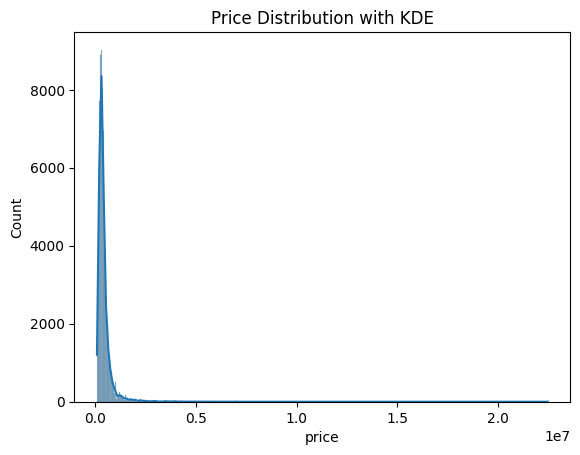

In [8]:
#Skeweneess without outliers

sns.histplot(df['price'], kde=True)
plt.title("Price Distribution with KDE")
plt.show()

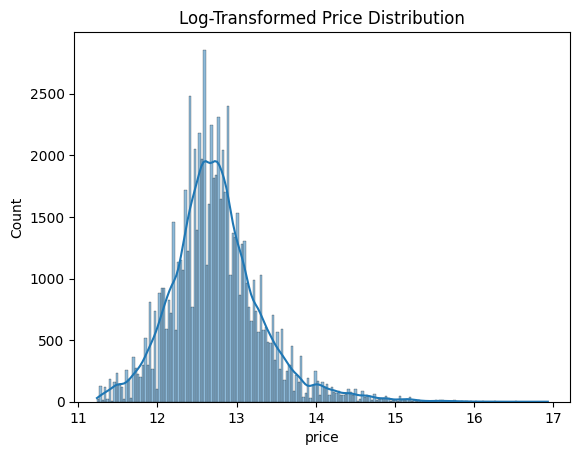

In [9]:
#Log-stransformed

sns.histplot(np.log1p(df['price']), kde=True)
plt.title("Log-Transformed Price Distribution")
plt.show()

In [10]:
# Skeweness of all numberic variables, ordered by skeweness
#≈ 0	Symmetric	
#0.5 – 1	Moderately right-skewed	
#> 1	Highly right-skewed (often needs log or power transform)	
#< -0.5	Left-skewed

num_cols = ['price', 'surface_land_sqm', 'total_area_sqm', 'garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']
df[num_cols].skew()


price                 9.449465
surface_land_sqm     68.585462
total_area_sqm      146.958438
garden_sqm           55.556399
terrace_sqm          48.555550
nbr_bedrooms         22.588000
nbr_frontages         3.155215
dtype: float64

In [11]:
# Capping/Winsorization: replace everything above the 99th/below the 1st percentile percentile with the 99th percentile/1str percentile value
df_before = df.copy() #keeping a copy of data before capping

cap_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']

# Choosingcapping percentiles (e.g. 1st and 99th)
lower_cap = 0.01
upper_cap = 0.99

for var in cap_vars:
    lower = df[var].quantile(lower_cap)
    upper = df[var].quantile(upper_cap)
    df[var] = np.where(df[var] < lower, lower,
                       np.where(df[var] > upper, upper, df[var]))

df[cap_vars].skew()

price               3.252231
surface_land_sqm    5.155961
total_area_sqm      2.475283
garden_sqm          5.132286
terrace_sqm         2.705177
nbr_bedrooms        1.002756
nbr_frontages       0.376808
dtype: float64

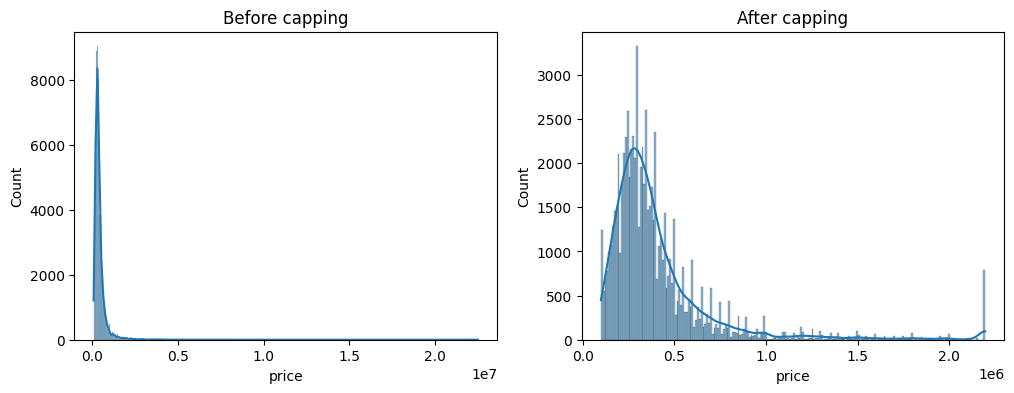

In [12]:
# Visuals before and after capping 'price'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_before['price'], kde=True, ax=axes[0])
axes[0].set_title("Before capping")
sns.histplot(df['price'], kde=True, ax=axes[1])
axes[1].set_title("After capping")
plt.show()

In [13]:
#Capping not enough (for 5 variables), so log transformation (may not be needed if later we do tree-based models like Random Forests, XGBoost, as they can handle skeweness)
# The result is pushing the distribution to be left-skewed but still price is nicely balanced
# The other variables are not jumping to the exrtreme of left-skeweness

import numpy as np

log_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm']

for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])

df[[f'{v}_log' for v in log_vars]].skew()



price_log               0.633032
surface_land_sqm_log   -1.389089
total_area_sqm_log      0.359023
garden_sqm_log          1.949138
terrace_sqm_log         0.382170
dtype: float64

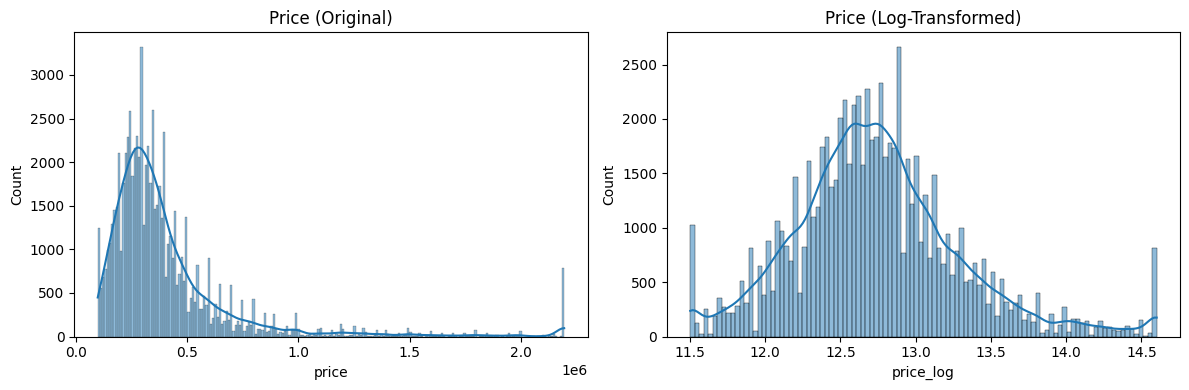

In [14]:
#Visuals for price
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['price'], kde=True, ax=axes[0])
axes[0].set_title("Price (Original)")
sns.histplot(df['price_log'], kde=True, ax=axes[1])
axes[1].set_title("Price (Log-Transformed)")
plt.tight_layout()
plt.show()